In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD/

Mounted at /content/gdrive
/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD


#Importing libraries

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, max_error
from sklearn.model_selection import ShuffleSplit

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
import joblib

In [ ]:
from sklearn import preprocessing
from scipy import stats
from copy import deepcopy


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [ ]:
import glob # to read multiple files
import os
from sklearn.model_selection import cross_val_predict
from collections import defaultdict
import json


#Loading fingerprints


In [ ]:
bioactivity_pIC50 = pd.read_csv('bioactivity_pIC50.csv')
pIC50 = bioactivity_pIC50 ['pIC50']
pIC50

In [ ]:
path = '/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD/'
file_names = [
    'AtomPairs2D.csv',
    'AtomPairs2DCount.csv',
    'SubstructureCount.csv',
    'Substructure.csv',
    'MACCS.csv',
    'CDKgraphonly.csv',
    'PubChem.csv',
    'CDK.csv',
    'EState.csv',
    'KlekotaRothCount.csv',
    'CDKextended.csv',
    'KlekotaRoth.csv'
]

fingerprint_dfs = {}

In [ ]:
path = '/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD/'
# List the contents of the directory
contents = os.listdir(path)

# Display the contents
for item in contents:
    print(item)

In [ ]:
for file_name in file_names:
    full_path = os.path.join(path, file_name)

    if os.path.exists(full_path):
        df_name = file_name.split('.')[0]
        df = pd.read_csv(full_path, header=0)

        # Set the name of the first column to 'ChEMBLID'
        df.columns.values[0] = 'ChEMBLID'

        csv_filename = f'ChEMBLID_{df_name}_Fingerprint.csv'
        df.to_csv(csv_filename, sep=',', index=False)

        fingerprint_dfs[df_name] = df
    else:
        print(f"File not found: {full_path}")

# Feature Selection

In [ ]:
def Remove_useless_descriptor(df, threshold):
    des1 = len(df.columns)

    # Identify non-numeric columns
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

    if non_numeric_columns:
        print(f"Non-numeric columns found: {non_numeric_columns}")
        print("Handling non-numeric values...")

        # Handle non-numeric values (replace or drop columns as needed)
        df = df.drop(columns=non_numeric_columns)

    h = df.columns.tolist()
    df_array = df.to_numpy().astype(float)

    # Create a VarianceThreshold instance
    selector = VarianceThreshold(threshold=threshold)

    df_array_selected = selector.fit_transform(df_array)

    idx = selector.get_support(indices=True)

    df_result = pd.DataFrame(df_array_selected, columns=np.array(h)[idx])

    des2 = len(df_result.columns)

    print('from Remove useless descriptor')
    print("The initial set of {} descriptors has been reduced to {} descriptors.".format(des1, des2))

    return df_result, des1, des2


In [ ]:
variance_result_dfs = {}

for file_name in file_names:
    full_path = path + file_name
    df_name = file_name.split('.')[0]

    current_df = pd.read_csv(full_path, header=0)

    result_df, des1, des2 = Remove_useless_descriptor(current_df, threshold=0.1)

    variance_result_dfs[df_name] = result_df

    print(f"Processed file: {file_name}")
    print(f"Initial number of descriptors: {des1}")
    print(f"Number of descriptors after removal: {des2}")
    print("")

    # Save the processed DataFrame to a CSV file
    result_df.to_csv(f'/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD/[Trial] New method for MD/variance_processed_{df_name}.csv', index=False)


Non-numeric columns found: ['Name']
Handling non-numeric values...
from Remove useless descriptor
The initial set of 308 descriptors has been reduced to 44 descriptors.
Processed file: SubstructureCount.csv
Initial number of descriptors: 308
Number of descriptors after removal: 44



In [ ]:
# defining correlation

def correlation(df, threshold):
    des3 = len(df.columns)
    col_corr = set()
    corr_matrix = df.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname]

    des4 = len(df.columns)

    print('from Remove correlation')
    print("The initial set of {} descriptors has been reduced to {} descriptors.".format(des3, des4))

    return df, des3, des4


In [ ]:
correlation_result_dfs = {}

for df_name, df in variance_result_dfs.items():
    result_df, des3, des4 = correlation(df, threshold=0.7)

    result_df = pd.concat([result_df, pIC50], axis=1)

    result_df.to_csv(f'/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD/[Trial] New method for MD/pIC50_correlation_processed_{df_name}.csv', index=False)

    correlation_result_dfs[df_name] = result_df

    print(f"Processed DataFrame: {df_name}")
    print(f"Initial number of descriptors: {des3}")
    print(f"Number of descriptors after correlation removal: {des4}")
    print(f"Added 'pIC50' column to DataFrame: {df_name}")
    print("")


from Remove correlation
The initial set of 44 descriptors has been reduced to 29 descriptors.
Processed DataFrame: SubstructureCount
Initial number of descriptors: 44
Number of descriptors after correlation removal: 29
Added 'pIC50' column to DataFrame: SubstructureCount



# Model Building + Validation


Y-Scrambling

In [ ]:
def Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name, split):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []


    # Do the Y-scrambling. Loop over the actual learning for 10 times.
    for randomseedcounter in range(1,11):
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled         = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1)
        RF_scrambled         = RF_scrambled.fit(X_internal,y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'Y_scrambling_results_{df_name}_split_{split}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

Plots

In [ ]:
def plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf):

    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'{df_name}_compare_Fp.png', dpi=300)


Model

In [ ]:
def build_model(X, Y, num_splits, hx, f, df_name):
    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAPE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAPE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': [],
        'MAPE_External': []
    }

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    for split in range(num_splits):
        seed = 42 + split
        X_internal, X_external, Y_internal, Y_external = train_test_split(X, Y, test_size=0.2, random_state=seed)

        # Internal set
        rf = RandomForestRegressor(random_state=seed, n_jobs=-1, verbose=1)
        rf.fit(X_internal, Y_internal)
        prediction_internal = rf.predict(X_internal)

        # Cross-validation
        cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

        # External set
        prediction_external = rf.predict(X_external)

        # Save the trained model using joblib
        model_filename = f'trained_model_{df_name}_split_{split}.joblib'
        joblib.dump(rf, model_filename)

        # Append the model to the list
        models.append(model_filename)

        # Store results for each split
        all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
        all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
        all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
        all_metrics_results['MAPE_train'].append(metrics.mean_absolute_percentage_error(Y_internal, prediction_internal))
        all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
        all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
        all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
        all_metrics_results['MAPE_CV'].append(metrics.mean_absolute_percentage_error(Y_internal, cv))
        all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
        all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
        all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))
        all_metrics_results['MAPE_External'].append(metrics.mean_absolute_percentage_error(Y_external, prediction_external))

        # Feature Importance
        feature_importance = rf.feature_importances_
        importances = list(zip(hx, feature_importance))
        importances = sorted(importances, key=lambda x: x[1], reverse=True)

        # Feature importance Visualization
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 5
        fig_size[1] = 10

        barlist = plt.barh(range(len(importances)), [x[1] for x in importances],
                          color="#27187eff", xerr=[x[1] for x in importances],
                          align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

        plt.yticks(range(len(importances)), [x[0] for x in importances])
        plt.ylim([-1, len(importances)])

        plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
        ax = plt.gca()
        ax.invert_yaxis()
        plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

        # Save the feature importance plot
        plt.savefig(f'{df_name}_Feature_importances_split_{split}.pdf', dpi=300)
        plt.close()

        # Store feature importances
        for i, fx in enumerate(hx):
            feature_importances_results['importances_dict'][fx].append(feature_importance[i])

        # Y Scrambling
        y_scrambling_results_internal_split, y_scrambling_results_external_split = Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name, split)

        y_scrambling_results_external.append(y_scrambling_results_external_split)
        y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    return all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf

#Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel

Built model for DataFrame: SubstructureCount



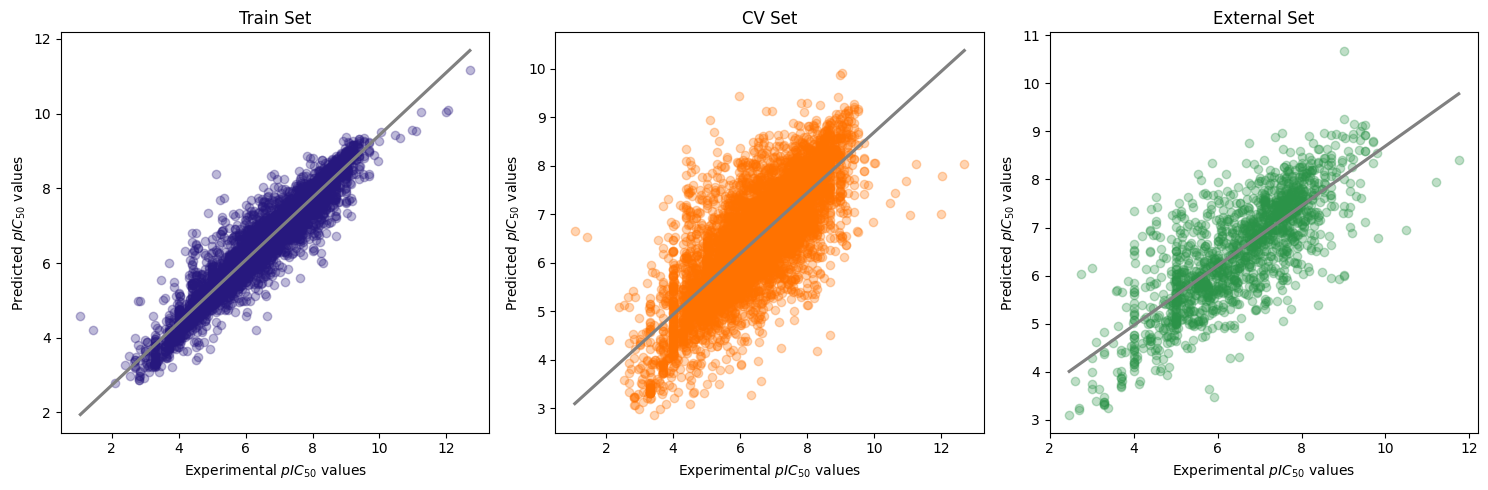

In [ ]:
# Define a base directory
base_dir = '/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[02] MD/New run with MAPE/'

# Running build_model function
model_results = {}

for df_name, df in correlation_result_dfs.items():
    pIC50_column = df['pIC50']
    X = df.drop(columns=['pIC50'])

    all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, _ = build_model(
        X,
        pIC50_column,
        num_splits=10,
        hx=X.columns.tolist(),
        f='pIC50',
        df_name=df_name
    )

    model_results[df_name] = all_metrics_results

    # CSV format for all metrics
    results_filename_csv_metrics = os.path.join(base_dir, f'model_results_{df_name}_metrics.csv')
    all_metrics_df = pd.DataFrame(all_metrics_results)
    all_metrics_df.to_csv(results_filename_csv_metrics, index=False)

    # CSV format for feature importances
    results_filename_csv_importances = os.path.join(base_dir, f'model_results_{df_name}_importances.csv')
    feature_importances_df = pd.DataFrame(feature_importances_results['importances_dict'])
    feature_importances_df.to_csv(results_filename_csv_importances, index=False)

    print(f"Built model for DataFrame: {df_name}")
    print("")
